<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = False
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [30]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [31]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [32]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [33]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [34]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [35]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

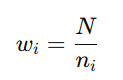

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [36]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [37]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 6:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [38]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [39]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [40]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [41]:
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}

  patiente = 100
  best_recall = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")

      if val_recall > best_recall:
        best_recall = val_recall
        patiente = 100
      else:
        patiente -= 1

      if patiente == 0:
        print("Early Sopping")
        break

  wandb.finish()

In [42]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2}
MODEL = architectures['resnet']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

WEIGHTS = [get_weights(),2.0]

learning_rate  = 1e-4

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 50, 'batch_size': 32, 'lr': 0.0001, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.4229647861576398]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.40950682524670945
Accuracy train epoch: 1  train_acc: 0.8434477756286267
F1 train epoch: 1  train_f1: 0.5877908512902064
Recall train epoch: 1  train_recall: 0.6077596871213892


Pèrdua validació epoch: 1  val_loss: 0.3591176294721663
Accuracy val epoch: 1  val_acc: 0.8828125
F1 val epoch: 1  val_f1: 0.6337697441340049
Recall val epoch: 1  val_reall: 0.5649012445887447


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.33465075194835664
Accuracy train epoch: 2  train_acc: 0.8741658607350097
F1 train epoch: 2  train_f1: 0.6622457197560947
Recall train epoch: 2  train_recall: 0.6906066746492276


Pèrdua validació epoch: 2  val_loss: 0.34542627166956663
Accuracy val epoch: 2  val_acc: 0.8666015625
F1 val epoch: 2  val_f1: 0.663739017937724
Recall val epoch: 2  val_reall: 0.7308396464646464


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.30393572123126783
Accuracy train epoch: 3  train_acc: 0.8909695357833656
F1 train epoch: 3  train_f1: 0.7059712422654661
Recall train epoch: 3  train_recall: 0.7446180533414579


Pèrdua validació epoch: 3  val_loss: 0.3090996234677732
Accuracy val epoch: 3  val_acc: 0.8828125
F1 val epoch: 3  val_f1: 0.6522028675980883
Recall val epoch: 3  val_reall: 0.6250304383116884


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.2837815935941453
Accuracy train epoch: 4  train_acc: 0.8967722437137331
F1 train epoch: 4  train_f1: 0.720805130030148
Recall train epoch: 4  train_recall: 0.7596648859414816


Pèrdua validació epoch: 4  val_loss: 0.4558881144039333
Accuracy val epoch: 4  val_acc: 0.88359375
F1 val epoch: 4  val_f1: 0.5944180411092176
Recall val epoch: 4  val_reall: 0.5288882124819624


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.25629845233039655
Accuracy train epoch: 5  train_acc: 0.9104569632495165
F1 train epoch: 5  train_f1: 0.7612635450972846
Recall train epoch: 5  train_recall: 0.7941936904702859


Pèrdua validació epoch: 5  val_loss: 0.3345956988632679
Accuracy val epoch: 5  val_acc: 0.88046875
F1 val epoch: 5  val_f1: 0.5963131741624388
Recall val epoch: 5  val_reall: 0.5483088092463093


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.24381224741327
Accuracy train epoch: 6  train_acc: 0.9131769825918762
F1 train epoch: 6  train_f1: 0.7740424216160338
Recall train epoch: 6  train_recall: 0.815582337284465


Pèrdua validació epoch: 6  val_loss: 0.3506184727884829
Accuracy val epoch: 6  val_acc: 0.8861328125
F1 val epoch: 6  val_f1: 0.6413174276274122
Recall val epoch: 6  val_reall: 0.581642316017316


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.22315838682524702
Accuracy train epoch: 7  train_acc: 0.922159090909091
F1 train epoch: 7  train_f1: 0.7929710655591694
Recall train epoch: 7  train_recall: 0.8333508335635997


Pèrdua validació epoch: 7  val_loss: 0.3505393383093178
Accuracy val epoch: 7  val_acc: 0.8912109375
F1 val epoch: 7  val_f1: 0.6549805275134223
Recall val epoch: 7  val_reall: 0.5945064484126984


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.2095819318548162
Accuracy train epoch: 8  train_acc: 0.9269946808510638
F1 train epoch: 8  train_f1: 0.8066951105456474
Recall train epoch: 8  train_recall: 0.8466257029022984


Pèrdua validació epoch: 8  val_loss: 0.3513655951246619
Accuracy val epoch: 8  val_acc: 0.8587890625
F1 val epoch: 8  val_f1: 0.6729694327967356
Recall val epoch: 8  val_reall: 0.7634548611111113


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.1911716376213317
Accuracy train epoch: 9  train_acc: 0.9311291102514506
F1 train epoch: 9  train_f1: 0.8161257210143692
Recall train epoch: 9  train_recall: 0.8562165848336062


Pèrdua validació epoch: 9  val_loss: 0.3106496977270581
Accuracy val epoch: 9  val_acc: 0.8984375
F1 val epoch: 9  val_f1: 0.7316234286546788
Recall val epoch: 9  val_reall: 0.7779333513708515


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.18521626062215643
Accuracy train epoch: 10  train_acc: 0.9337161508704063
F1 train epoch: 10  train_f1: 0.8245607758911292
Recall train epoch: 10  train_recall: 0.8696945253328232


Pèrdua validació epoch: 10  val_loss: 0.3176731893909164
Accuracy val epoch: 10  val_acc: 0.9111328125
F1 val epoch: 10  val_f1: 0.7337648827780408
Recall val epoch: 10  val_reall: 0.6547743055555556


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.17786084494375168
Accuracy train epoch: 11  train_acc: 0.9363152804642166
F1 train epoch: 11  train_f1: 0.8243668684476281
Recall train epoch: 11  train_recall: 0.8646260477111543


Pèrdua validació epoch: 11  val_loss: 0.3207662563654594
Accuracy val epoch: 11  val_acc: 0.904296875
F1 val epoch: 11  val_f1: 0.7256966717493035
Recall val epoch: 11  val_reall: 0.6950971771284272


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.15515046508863886
Accuracy train epoch: 12  train_acc: 0.9486702127659574
F1 train epoch: 12  train_f1: 0.8537603599283677
Recall train epoch: 12  train_recall: 0.8874828717381912


Pèrdua validació epoch: 12  val_loss: 0.3726746962638572
Accuracy val epoch: 12  val_acc: 0.90625
F1 val epoch: 12  val_f1: 0.7126746984525625
Recall val epoch: 12  val_reall: 0.6514632936507936


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.1385755227839059
Accuracy train epoch: 13  train_acc: 0.9537959381044488
F1 train epoch: 13  train_f1: 0.8714571524399604
Recall train epoch: 13  train_recall: 0.9020380092720522


Pèrdua validació epoch: 13  val_loss: 0.3775869843084365
Accuracy val epoch: 13  val_acc: 0.8845703125
F1 val epoch: 13  val_f1: 0.7020561581199158
Recall val epoch: 13  val_reall: 0.7298954517704519


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.13799234735680388
Accuracy train epoch: 14  train_acc: 0.9560565764023211
F1 train epoch: 14  train_f1: 0.8783912292711193
Recall train epoch: 14  train_recall: 0.9091509436190288


Pèrdua validació epoch: 14  val_loss: 0.37135255988687277
Accuracy val epoch: 14  val_acc: 0.890625
F1 val epoch: 14  val_f1: 0.7112313239633118
Recall val epoch: 14  val_reall: 0.7450013528138528


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.1255601546152475
Accuracy train epoch: 15  train_acc: 0.959115087040619
F1 train epoch: 15  train_f1: 0.8884815273278172
Recall train epoch: 15  train_recall: 0.922645864773525


Pèrdua validació epoch: 15  val_loss: 0.29465749132214114
Accuracy val epoch: 15  val_acc: 0.91953125
F1 val epoch: 15  val_f1: 0.7528766678582857
Recall val epoch: 15  val_reall: 0.7291666666666667


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.12763958305041206
Accuracy train epoch: 16  train_acc: 0.9577852998065765
F1 train epoch: 16  train_f1: 0.8858962841524284
Recall train epoch: 16  train_recall: 0.9280011359798599


Pèrdua validació epoch: 16  val_loss: 0.2861524446634576
Accuracy val epoch: 16  val_acc: 0.9111328125
F1 val epoch: 16  val_f1: 0.7196567321567323
Recall val epoch: 16  val_reall: 0.6793628246753247


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.11405280192006141
Accuracy train epoch: 17  train_acc: 0.9642408123791102
F1 train epoch: 17  train_f1: 0.8962907606092224
Recall train epoch: 17  train_recall: 0.9292396728566945


Pèrdua validació epoch: 17  val_loss: 0.4633834569249302
Accuracy val epoch: 17  val_acc: 0.9013671875
F1 val epoch: 17  val_f1: 0.7007455269403801
Recall val epoch: 17  val_reall: 0.6773065476190476


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.10884525495323728
Accuracy train epoch: 18  train_acc: 0.9619197292069633
F1 train epoch: 18  train_f1: 0.8944404626691702
Recall train epoch: 18  train_recall: 0.9219781400632465


Pèrdua validació epoch: 18  val_loss: 0.3136585430474952
Accuracy val epoch: 18  val_acc: 0.892578125
F1 val epoch: 18  val_f1: 0.7301344488844489
Recall val epoch: 18  val_reall: 0.8046750992063493


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.10531034365771932
Accuracy train epoch: 19  train_acc: 0.9654376208897485
F1 train epoch: 19  train_f1: 0.9079010256780871
Recall train epoch: 19  train_recall: 0.9402723399531913


Pèrdua validació epoch: 19  val_loss: 0.3372294362052344
Accuracy val epoch: 19  val_acc: 0.9041015625
F1 val epoch: 19  val_f1: 0.7226237497667454
Recall val epoch: 19  val_reall: 0.7263268849206351


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.09265458452654012
Accuracy train epoch: 20  train_acc: 0.9693544487427467
F1 train epoch: 20  train_f1: 0.9108915701216007
Recall train epoch: 20  train_recall: 0.9443290043290045


Pèrdua validació epoch: 20  val_loss: 0.32925145304761827
Accuracy val epoch: 20  val_acc: 0.89453125
F1 val epoch: 20  val_f1: 0.7284602172745557
Recall val epoch: 20  val_reall: 0.8201923076923079


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.08979924460080393
Accuracy train epoch: 21  train_acc: 0.9696808510638298
F1 train epoch: 21  train_f1: 0.9116948584482376
Recall train epoch: 21  train_recall: 0.9434642780387467


Pèrdua validació epoch: 21  val_loss: 0.3719442553119734
Accuracy val epoch: 21  val_acc: 0.9001953125
F1 val epoch: 21  val_f1: 0.7382617982400299
Recall val epoch: 21  val_reall: 0.7915340735653237


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.08752784729994675
Accuracy train epoch: 22  train_acc: 0.9684477756286267
F1 train epoch: 22  train_f1: 0.9085221850952041
Recall train epoch: 22  train_recall: 0.94781504547462


Pèrdua validació epoch: 22  val_loss: 0.41004981379956007
Accuracy val epoch: 22  val_acc: 0.89140625
F1 val epoch: 22  val_f1: 0.6942246922002148
Recall val epoch: 22  val_reall: 0.6600446428571429


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.0790112546070459
Accuracy train epoch: 23  train_acc: 0.9765352998065765
F1 train epoch: 23  train_f1: 0.9345315914195779
Recall train epoch: 23  train_recall: 0.953149486447359


Pèrdua validació epoch: 23  val_loss: 0.5040220233495347
Accuracy val epoch: 23  val_acc: 0.900390625
F1 val epoch: 23  val_f1: 0.6997139196587725
Recall val epoch: 23  val_reall: 0.6386386183261183


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.08025028595621599
Accuracy train epoch: 24  train_acc: 0.9736097678916829
F1 train epoch: 24  train_f1: 0.9228072567555853
Recall train epoch: 24  train_recall: 0.9452103097847782


Pèrdua validació epoch: 24  val_loss: 0.37736894479894545
Accuracy val epoch: 24  val_acc: 0.894140625
F1 val epoch: 24  val_f1: 0.7479747916449737
Recall val epoch: 24  val_reall: 0.7951884920634921


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.0776944717184264
Accuracy train epoch: 25  train_acc: 0.9748065764023212
F1 train epoch: 25  train_f1: 0.9286689399790647
Recall train epoch: 25  train_recall: 0.9542262583751947


Pèrdua validació epoch: 25  val_loss: 0.4123058722470887
Accuracy val epoch: 25  val_acc: 0.894921875
F1 val epoch: 25  val_f1: 0.7209198978060871
Recall val epoch: 25  val_reall: 0.7504588293650793


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.07606803441340936
Accuracy train epoch: 26  train_acc: 0.9756648936170212
F1 train epoch: 26  train_f1: 0.933480548552151
Recall train epoch: 26  train_recall: 0.9604923681519426


Pèrdua validació epoch: 26  val_loss: 0.3594173443270847
Accuracy val epoch: 26  val_acc: 0.91640625
F1 val epoch: 26  val_f1: 0.7514242701742703
Recall val epoch: 26  val_reall: 0.7406746031746032


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.06831275110895885
Accuracy train epoch: 27  train_acc: 0.97946083172147
F1 train epoch: 27  train_f1: 0.9383895069625947
Recall train epoch: 27  train_recall: 0.9630408952749382


Pèrdua validació epoch: 27  val_loss: 0.3322212985949591
Accuracy val epoch: 27  val_acc: 0.9130859375
F1 val epoch: 27  val_f1: 0.7704344478942969
Recall val epoch: 27  val_reall: 0.7955481150793653


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.06770646632649005
Accuracy train epoch: 28  train_acc: 0.979654255319149
F1 train epoch: 28  train_f1: 0.9438834686308505
Recall train epoch: 28  train_recall: 0.9626930398206996


Pèrdua validació epoch: 28  val_loss: 0.47840811213245615
Accuracy val epoch: 28  val_acc: 0.898046875
F1 val epoch: 28  val_f1: 0.7212014950671105
Recall val epoch: 28  val_reall: 0.7005952380952382


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.058893422913697965
Accuracy train epoch: 29  train_acc: 0.9812620889748549
F1 train epoch: 29  train_f1: 0.9483630597968314
Recall train epoch: 29  train_recall: 0.9667480391948475


Pèrdua validació epoch: 29  val_loss: 0.3928215065971017
Accuracy val epoch: 29  val_acc: 0.9189453125
F1 val epoch: 29  val_f1: 0.7799434174893736
Recall val epoch: 29  val_reall: 0.8005027958152958


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.06912401360905472
Accuracy train epoch: 30  train_acc: 0.9777925531914894
F1 train epoch: 30  train_f1: 0.9320533470072373
Recall train epoch: 30  train_recall: 0.9592626876669432


Pèrdua validació epoch: 30  val_loss: 0.4162039860384539
Accuracy val epoch: 30  val_acc: 0.9060546875
F1 val epoch: 30  val_f1: 0.7200051684426686
Recall val epoch: 30  val_reall: 0.6986697330447332


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.06372179136552075
Accuracy train epoch: 31  train_acc: 0.9801982591876208
F1 train epoch: 31  train_f1: 0.941420035847381
Recall train epoch: 31  train_recall: 0.9666658636871405


Pèrdua validació epoch: 31  val_loss: 0.43913340033032
Accuracy val epoch: 31  val_acc: 0.894140625
F1 val epoch: 31  val_f1: 0.7188424586034882
Recall val epoch: 31  val_reall: 0.7604452838827839


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.06124151971369506
Accuracy train epoch: 32  train_acc: 0.9806576402321083
F1 train epoch: 32  train_f1: 0.9469300049493402
Recall train epoch: 32  train_recall: 0.9635316692763506


Pèrdua validació epoch: 32  val_loss: 0.4437473734287778
Accuracy val epoch: 32  val_acc: 0.91875
F1 val epoch: 32  val_f1: 0.7447136586431287
Recall val epoch: 32  val_reall: 0.7012524801587302


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.055471205702447825
Accuracy train epoch: 33  train_acc: 0.9826523210831722
F1 train epoch: 33  train_f1: 0.9446021647066721
Recall train epoch: 33  train_recall: 0.9601616468637746


Pèrdua validació epoch: 33  val_loss: 0.4152691811323166
Accuracy val epoch: 33  val_acc: 0.9169921875
F1 val epoch: 33  val_f1: 0.7740870141532874
Recall val epoch: 33  val_reall: 0.7709021013708516


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.06310504272560331
Accuracy train epoch: 34  train_acc: 0.9799202127659574
F1 train epoch: 34  train_f1: 0.9448394785364711
Recall train epoch: 34  train_recall: 0.9629622032813523


Pèrdua validació epoch: 34  val_loss: 0.5055972814006964
Accuracy val epoch: 34  val_acc: 0.8974609375
F1 val epoch: 34  val_f1: 0.6774760875089822
Recall val epoch: 34  val_reall: 0.6118799603174604


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.05135467283804208
Accuracy train epoch: 35  train_acc: 0.9832446808510639
F1 train epoch: 35  train_f1: 0.9534481460616104
Recall train epoch: 35  train_recall: 0.9670321758619631


Pèrdua validació epoch: 35  val_loss: 0.4533249551313929
Accuracy val epoch: 35  val_acc: 0.9158203125
F1 val epoch: 35  val_f1: 0.7181053783462841
Recall val epoch: 35  val_reall: 0.6807291666666667


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.05959188147606526
Accuracy train epoch: 36  train_acc: 0.9815159574468085
F1 train epoch: 36  train_f1: 0.9415838912748925
Recall train epoch: 36  train_recall: 0.966321834194175


Pèrdua validació epoch: 36  val_loss: 0.3288765006000176
Accuracy val epoch: 36  val_acc: 0.9244140625
F1 val epoch: 36  val_f1: 0.7877815760628263
Recall val epoch: 36  val_reall: 0.739977904040404


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.05011366666889096
Accuracy train epoch: 37  train_acc: 0.9850459381044488
F1 train epoch: 37  train_f1: 0.958952251628953
Recall train epoch: 37  train_recall: 0.9692279942279947


Pèrdua validació epoch: 37  val_loss: 0.4424256676720688
Accuracy val epoch: 37  val_acc: 0.90234375
F1 val epoch: 37  val_f1: 0.6899349916401969
Recall val epoch: 37  val_reall: 0.6591384310134311


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.049228663353665554
Accuracy train epoch: 38  train_acc: 0.9851063829787234
F1 train epoch: 38  train_f1: 0.956768924292216
Recall train epoch: 38  train_recall: 0.9762592490252067


Pèrdua validació epoch: 38  val_loss: 0.40669603592687054
Accuracy val epoch: 38  val_acc: 0.91796875
F1 val epoch: 38  val_f1: 0.7779006328638682
Recall val epoch: 38  val_reall: 0.7705684072871573


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.04024229530279742
Accuracy train epoch: 39  train_acc: 0.9881648936170213
F1 train epoch: 39  train_f1: 0.9648129482517863
Recall train epoch: 39  train_recall: 0.9770123729698198


Pèrdua validació epoch: 39  val_loss: 0.35578786495534587
Accuracy val epoch: 39  val_acc: 0.92578125
F1 val epoch: 39  val_f1: 0.7871590924125755
Recall val epoch: 39  val_reall: 0.772623556998557


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.050257669310977165
Accuracy train epoch: 40  train_acc: 0.9838491295938105
F1 train epoch: 40  train_f1: 0.9578669803780825
Recall train epoch: 40  train_recall: 0.9710405551894916


Pèrdua validació epoch: 40  val_loss: 0.3609751770272851
Accuracy val epoch: 40  val_acc: 0.9109375
F1 val epoch: 40  val_f1: 0.7464923819945107
Recall val epoch: 40  val_reall: 0.7837290313852816


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.04293208914967452
Accuracy train epoch: 41  train_acc: 0.9866416827852998
F1 train epoch: 41  train_f1: 0.9514556782391577
Recall train epoch: 41  train_recall: 0.9774279266832457


Pèrdua validació epoch: 41  val_loss: 0.43200788024114445
Accuracy val epoch: 41  val_acc: 0.90703125
F1 val epoch: 41  val_f1: 0.7557650779303258
Recall val epoch: 41  val_reall: 0.7687500000000002


Batches (Època 42): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 42  train_loss: 0.041917960650901843
Accuracy train epoch: 42  train_acc: 0.9869076402321084
F1 train epoch: 42  train_f1: 0.9634501415191096
Recall train epoch: 42  train_recall: 0.9737419790611284


Pèrdua validació epoch: 42  val_loss: 0.38508050596283283
Accuracy val epoch: 42  val_acc: 0.9041015625
F1 val epoch: 42  val_f1: 0.7577058169088768
Recall val epoch: 42  val_reall: 0.8350175865800868


Batches (Època 43): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 43  train_loss: 0.057548898018084146
Accuracy train epoch: 43  train_acc: 0.9817214700193424
F1 train epoch: 43  train_f1: 0.9488497053916074
Recall train epoch: 43  train_recall: 0.9682943415922138


Pèrdua validació epoch: 43  val_loss: 0.3526437996770255
Accuracy val epoch: 43  val_acc: 0.912109375
F1 val epoch: 43  val_f1: 0.7660621045513655
Recall val epoch: 43  val_reall: 0.7941423160173161


Batches (Època 44): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 44  train_loss: 0.04501888448412114
Accuracy train epoch: 44  train_acc: 0.9859042553191489
F1 train epoch: 44  train_f1: 0.9602862866005608
Recall train epoch: 44  train_recall: 0.9744720409614027


Pèrdua validació epoch: 44  val_loss: 0.31584634637692943
Accuracy val epoch: 44  val_acc: 0.9189453125
F1 val epoch: 44  val_f1: 0.7721604835115866
Recall val epoch: 44  val_reall: 0.7936214826839828


Batches (Època 45): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 45  train_loss: 0.03621540328480323
Accuracy train epoch: 45  train_acc: 0.9884308510638298
F1 train epoch: 45  train_f1: 0.9672989376656147
Recall train epoch: 45  train_recall: 0.9805896939939495


Pèrdua validació epoch: 45  val_loss: 0.39136770518962294
Accuracy val epoch: 45  val_acc: 0.9072265625
F1 val epoch: 45  val_f1: 0.7066624866039535
Recall val epoch: 45  val_reall: 0.7071800595238096


Batches (Època 46): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 46  train_loss: 0.0404400137200471
Accuracy train epoch: 46  train_acc: 0.988031914893617
F1 train epoch: 46  train_f1: 0.962166479671585
Recall train epoch: 46  train_recall: 0.9762778238310154


Pèrdua validació epoch: 46  val_loss: 0.45170317171141505
Accuracy val epoch: 46  val_acc: 0.9029296875
F1 val epoch: 46  val_f1: 0.7502277972285714
Recall val epoch: 46  val_reall: 0.7744521103896105


Batches (Època 47): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 47  train_loss: 0.04250308396591944
Accuracy train epoch: 47  train_acc: 0.9889627659574468
F1 train epoch: 47  train_f1: 0.9692770050497821
Recall train epoch: 47  train_recall: 0.9782492684620343


Pèrdua validació epoch: 47  val_loss: 0.4200632660649717
Accuracy val epoch: 47  val_acc: 0.908984375
F1 val epoch: 47  val_f1: 0.7315497309063486
Recall val epoch: 47  val_reall: 0.7270089285714287


Batches (Època 48): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 48  train_loss: 0.03173447309700931
Accuracy train epoch: 48  train_acc: 0.9910299806576403
F1 train epoch: 48  train_f1: 0.9739077262972264
Recall train epoch: 48  train_recall: 0.9830494918792793


Pèrdua validació epoch: 48  val_loss: 0.3932462737429887
Accuracy val epoch: 48  val_acc: 0.90703125
F1 val epoch: 48  val_f1: 0.7487818497614357
Recall val epoch: 48  val_reall: 0.8196924603174602


Batches (Època 49): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 49  train_loss: 0.03298861098220631
Accuracy train epoch: 49  train_acc: 0.9900265957446809
F1 train epoch: 49  train_f1: 0.9693925642311785
Recall train epoch: 49  train_recall: 0.9786894783703296


Pèrdua validació epoch: 49  val_loss: 0.4747516491333954
Accuracy val epoch: 49  val_acc: 0.91875
F1 val epoch: 49  val_f1: 0.7686754856985122
Recall val epoch: 49  val_reall: 0.717733134920635


Batches (Època 50): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 50  train_loss: 0.043086947417419225
Accuracy train epoch: 50  train_acc: 0.9867021276595744
F1 train epoch: 50  train_f1: 0.9643686423362994
Recall train epoch: 50  train_recall: 0.9745765227680123


Pèrdua validació epoch: 50  val_loss: 0.5114471420265545
Accuracy val epoch: 50  val_acc: 0.9080078125
F1 val epoch: 50  val_f1: 0.7441171197653396
Recall val epoch: 50  val_reall: 0.7581225198412699


train/train_acc,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██▇████████████
train/train_f1,▁▂▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇███████████
train/train_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇███▇█▇█████
train/train_recall,▁▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
val/val_acc,▄▂▄▄▃▄▁▅▆▆▄▇▆▅▅▅▅▄▅▅▇▇▅▇▆▇▇▅▇█▇█▆▆▆▆▆▆▆▆
val/val_f1,▂▄▃▁▁▃▆▆▆▅▅▇▆▅▆▆▆▅▅▇▇▇▆█▆█▄▅█▄█▇▇▇▇▅▇▆▇▆
val/val_loss,▃▃▂▆▃▃▃▂▂▂▄▄▁▁▂▂▄▅█▄▃▂▇▄▅▆▅█▆▂▅▃▆▄▃▄▆▅▄█
val/val_precision,▅▁▄▅▄▅▁▄█▆▄▃▆▆▅▅▃▄▆▇▄▆▅▆▆▄▇▆▆▇▆▇▇▅▅▅▆▆▄▅
val/val_recall,▂▆▃▁▁▃▆▇▄▅▆▆▆▄▇▇▄▄▇▆▇▅▇▅▆▇▃▄▆▄▇▇▆█▇▅▇▆█▆
train/train_acc,0.9867


{'epochs': 50, 'batch_size': 32, 'lr': 0.0001, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [2.0]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.4843633053150583
Accuracy train epoch: 1  train_acc: 0.8260033849129594
F1 train epoch: 1  train_f1: 0.5970416074575539
Recall train epoch: 1  train_recall: 0.6978201467563169


Pèrdua validació epoch: 1  val_loss: 0.4396197171881795
Accuracy val epoch: 1  val_acc: 0.821875
F1 val epoch: 1  val_f1: 0.6274554900051267
Recall val epoch: 1  val_reall: 0.8230778769841272


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.4170923671823867
Accuracy train epoch: 2  train_acc: 0.8547993230174081
F1 train epoch: 2  train_f1: 0.6478493091828554
Recall train epoch: 2  train_recall: 0.755036382057659


Pèrdua validació epoch: 2  val_loss: 0.4032448504585773
Accuracy val epoch: 2  val_acc: 0.865234375
F1 val epoch: 2  val_f1: 0.572451649657532
Recall val epoch: 2  val_reall: 0.5392733134920635


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.37290044585441023
Accuracy train epoch: 3  train_acc: 0.8774782398452612
F1 train epoch: 3  train_f1: 0.6968304419306988
Recall train epoch: 3  train_recall: 0.7918825854996069


Pèrdua validació epoch: 3  val_loss: 0.4065664755180478
Accuracy val epoch: 3  val_acc: 0.8853515625
F1 val epoch: 3  val_f1: 0.6671026022588524
Recall val epoch: 3  val_reall: 0.6513607052669552


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.3383383114287194
Accuracy train epoch: 4  train_acc: 0.8895188588007736
F1 train epoch: 4  train_f1: 0.7270940101001419
Recall train epoch: 4  train_recall: 0.8231294828103339


Pèrdua validació epoch: 4  val_loss: 0.3747459384612739
Accuracy val epoch: 4  val_acc: 0.8451171875
F1 val epoch: 4  val_f1: 0.6443065456537787
Recall val epoch: 4  val_reall: 0.8054229624542124


Batches (Època 5): 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(training.__len__())